In [1]:
import pandas as pd
import time
import os
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import TargetEncoder, StandardScaler
import matplotlib.pyplot as plt
from itertools import combinations, product
from  lightgbm import LGBMClassifier
from  xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, VotingClassifier
from sklearn.metrics import roc_auc_score, classification_report
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from category_encoders import WOEEncoder
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPClassifier
from hyperopt import tpe, fmin, Trials, hp, space_eval
from hyperopt.early_stop import no_progress_loss
from sklearn.base import BaseEstimator, TransformerMixin
import gc
import psutil

In [2]:
print(f"Доступно памяти: {psutil.virtual_memory().available / 1024**3:.1f} GB")

Доступно памяти: 20.9 GB


In [3]:
gc.collect()

20

## DataPreparation

In [19]:

path = "C:/Users/vasan/ML итоговый проект/train_data/train_data"
path_target = "C:/Users/vasan/ML итоговый проект/train_target.csv"

def data_transformation(path, path_target):
    
    def checking_data(path):
        l_data = []
        for file in os.listdir(path):
            file_path = os.path.join(path, file)
            if os.path.isfile(file_path):
                time_start = time.time()
                data = pd.read_parquet(file_path)
                data = data.drop_duplicates()
                l_num = list(data.select_dtypes(include="number").columns)
                for column in data.columns:
                    if column in l_num:
                        data[column] = data[column].fillna(data[column].median())
                    else:
                        data[column] = data[column].fillna(data[column].mode()[0])

                for i in range(0,2):
                    if i ==0:
                        df1 = data.loc[data["is_zero_util"]==i, :]
                        df1 = df1.copy()
                        df1[["sum_Loan5_op", "sum_loan530_op", "sum_loan3060_op", "sum_loan6090_op", "sum_loan90_op"]] = 0
                        df1["sum_open_credits"] = 1
                        df1[['pclose_flag_op', 'fclose_flag_op']]=df1[['pclose_flag','fclose_flag']]
                        columns11 = ['is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060',
                               'is_zero_loans6090', 'is_zero_loans90', 'is_zero_over2limit',
                               'is_zero_maxover2limit']
                        columns12 = [ "sum_Loan5_op", "sum_loan530_op", "sum_loan3060_op", "sum_loan6090_op", "sum_loan90_op", "sum_over2limit_op", "sum_maxover2limit_op"]
                        
                        for column11, column12 in zip(columns11, columns12):
                            df1.loc[df1[column11] == 0, column12] = 1    
                        df10 = df1.groupby("id")[["sum_Loan5_op", "sum_loan530_op", "sum_loan3060_op", "sum_loan6090_op", "sum_loan90_op","sum_open_credits",
                                                  "sum_over2limit_op", "sum_maxover2limit_op", 'pclose_flag_op', 'fclose_flag_op']].sum().reset_index()
                        df12 = data.loc[data["is_zero_util"]==i, :]
                        df12 = df12.copy()
                        df12 = df12.drop(columns = columns11)
                        df13 = df12.copy()
                        l_12 = list(df12.drop(columns = "id").columns)
                        l_13 = list(df13.drop(columns = "id").columns)
                        for column in l_12:
                            df12[f"{column}_open"] = df12[column]
                            df13[f"{column}_open_median"] = df13[column]
                        df12 = df12.drop(columns = l_12)
                        df13 = df13.drop(columns = l_13)
                        df12 = df12.sort_values("rn_open").groupby("id").last().reset_index()
                        df13 = df13.sort_values("rn_open_median").groupby("id").median().reset_index()
                        df11 = df10.merge(df12, on = "id", how = "inner").merge(df13, on = "id", how = "inner")
                    else:
                        df2 = data.loc[data["is_zero_util"]==i, :]
                        df2 = df2.copy()
                        df2[["sum_Loan5_cd", "sum_loan530_cd", "sum_loan3060_cd", "sum_loan6090_cd", "sum_loan90_cd"]] = 0
                        df2["sum_closed_credits"] = df2["is_zero_util"]
                        df2[['pclose_flag_cd', 'fclose_flag_cd']]=df2[['pclose_flag','fclose_flag']]
                        columns21 = ['is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060',
                               'is_zero_loans6090', 'is_zero_loans90', 'is_zero_over2limit',
                               'is_zero_maxover2limit']
                        columns22 = [ "sum_Loan5_cd", "sum_loan530_cd", "sum_loan3060_cd", "sum_loan6090_cd", "sum_loan90_cd", "sum_over2limit_cd", "sum_maxover2limit_cd"]
                        
                        for column21, column22 in zip(columns21, columns22):
                            df2.loc[df2[column21] == , column22] = 1    
                        df20 = df2.groupby("id")[["sum_Loan5_cd", "sum_loan530_cd", "sum_loan3060_cd", "sum_loan6090_cd", "sum_loan90_cd","sum_closed_credits", 
                                                  'sum_over2limit_cd','sum_maxover2limit_cd', 'pclose_flag_cd', 'fclose_flag_cd']].sum().reset_index()
                        df22 = data.loc[data["is_zero_util"]==i, :]
                        df22 = df22.copy()
                        df22 = df22.drop(columns = columns11)
                        df23 = df22.copy()
                        l_22 = list(df22.drop(columns = "id").columns)
                        l_23 = list(df23.drop(columns = "id").columns)
                        for column in l_22:
                            df22[f"{column}_closed"] = df22[column]
                            df23[f"{column}_closed_median"] = df23[column]
                        df22 = df22.drop(columns = l_22)
                        df23 = df23.drop(columns = l_23)
                        df22 = df22.sort_values("rn_closed").groupby("id").last().reset_index()
                        df23 = df23.sort_values("rn_closed_median").groupby("id").median().reset_index()
                        df21 = df20.merge(df22, on = "id", how = "inner").merge(df23, on = "id", how = "inner")
                df_merge = df11.merge(df21, on = "id", how = "outer").fillna(-1)
                columns = ["sum_Loan5_op", "sum_loan530_op", "sum_loan3060_op", "sum_loan6090_op", "sum_loan90_op","sum_open_credits",
                           "sum_over2limit_op", "sum_maxover2limit_op", 'pclose_flag_op', 'fclose_flag_op',"sum_Loan5_cd", "sum_loan530_cd",
                           "sum_loan3060_cd", "sum_loan6090_cd", "sum_loan90_cd","sum_closed_credits", 'sum_over2limit_cd','sum_maxover2limit_cd',
                           'pclose_flag_cd', 'fclose_flag_cd']
                df_merge[columns] = df_merge[columns].replace(-1,0) 
                df_merge = df_merge.drop(columns = ["rn_open", "rn_open_median", "rn_closed", "rn_closed_median"]) 
                df_merge[df_merge.drop(columns = "id").columns] = df_merge[df_merge.drop(columns = "id").columns].astype("int8")
                l_data.append(df_merge)
                time_end = time.time()
                del data
                print (f" {file} обработан за {round(time_end-time_start)} секунд")
            else:
                continue
        print("checking is finished")       
        return l_data
    
    l_data = checking_data(path)
    
    def concatination(l_data):
        
        df_concat = pd.concat(l_data, ignore_index = True)

       
        print("concatination is finished")
        return df_concat

    df_concat = concatination(l_data)


    def merge(df_concat, path_target):
        df_target = pd.read_csv(path_target)

        if len(df_concat) != len(df_target):
            df_concat = df_concat.drop_duplicates()
            df_concat = df_concat.groupby("id")[df_concat.drop(columns = "id").columns].sum().round().reset_index()
            print("есть повторяющиеся id")
            
        df_total = df_concat.merge(df_target, on = "id", how = "inner")
        


        print("merge is finished")
        
        return df_total

    df_total = merge(df_concat, path_target)

    def Recording(df_total):

        path_df_total = os.path.join(path, "engineering")
        if not os.path.exists(path_df_total):
            os.makedirs(path_df_total)
        path_total = os.path.join(path_df_total, "df_total.parquet")
        df_total.to_parquet(path_total, index = False)

        print("recording is finished")
        return df_total

    df_total = Recording(df_total)

    del df_concat

    gc.collect()
    print(f" размер полученного датасета {df_total.shape}")
    return df_total

In [20]:
df = data_transformation(path, path_target)

 train_data_0.pq обработан за 13 секунд
 train_data_1.pq обработан за 13 секунд
 train_data_10.pq обработан за 13 секунд
 train_data_11.pq обработан за 14 секунд
 train_data_2.pq обработан за 13 секунд
 train_data_3.pq обработан за 12 секунд
 train_data_4.pq обработан за 12 секунд
 train_data_5.pq обработан за 13 секунд
 train_data_6.pq обработан за 14 секунд
 train_data_7.pq обработан за 15 секунд
 train_data_8.pq обработан за 14 секунд
 train_data_9.pq обработан за 15 секунд
checking is finished
concatination is finished
merge is finished
recording is finished
 размер полученного датасета (3000000, 230)


In [6]:
df["id"].nunique()

3000000

In [4]:
df = pd.read_parquet("C:/Users/vasan/ML итоговый проект/train_data/train_data/engineering/df_total.parquet")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Columns: 230 entries, id to flag
dtypes: int64(2), int8(228)
memory usage: 698.1 MB


In [7]:
df.columns

Index(['id', 'sum_Loan5_op', 'sum_loan530_op', 'sum_loan3060_op',
       'sum_loan6090_op', 'sum_loan90_op', 'sum_open_credits',
       'sum_over2limit_op', 'sum_maxover2limit_op', 'pclose_flag_op',
       ...
       'enc_paym_22_closed_median', 'enc_paym_23_closed_median',
       'enc_paym_24_closed_median',
       'enc_loans_account_holder_type_closed_median',
       'enc_loans_credit_status_closed_median',
       'enc_loans_credit_type_closed_median',
       'enc_loans_account_cur_closed_median', 'pclose_flag_closed_median',
       'fclose_flag_closed_median', 'flag'],
      dtype='object', length=230)

In [8]:
df.head()

,id,sum_Loan5_op,sum_loan530_op,sum_loan3060_op,sum_loan6090_op,sum_loan90_op,sum_open_credits,sum_over2limit_op,sum_maxover2limit_op,pclose_flag_op,...,enc_paym_22_closed_median,enc_paym_23_closed_median,enc_paym_24_closed_median,enc_loans_account_holder_type_closed_median,enc_loans_credit_status_closed_median,enc_loans_credit_type_closed_median,enc_loans_account_cur_closed_median,pclose_flag_closed_median,fclose_flag_closed_median,flag
0,0,0,0,0,0,0,4,1,1,1,...,3,3,4,1,3,4,1,0,0,0
1,1,0,2,2,2,2,4,2,3,1,...,3,3,4,1,3,4,1,0,0,0
2,2,0,1,1,1,0,2,0,1,2,...,3,3,4,1,3,4,1,0,0,0
3,3,0,0,0,0,0,7,1,1,4,...,3,3,4,1,3,4,1,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,3,3,4,1,2,3,1,1,1,0


## Modeling

In [9]:
models = [LogisticRegression(), LGBMClassifier(), HistGradientBoostingClassifier(), XGBClassifier()]
val, other = train_test_split(df, train_size=0.3, random_state=42, stratify=df["flag"], shuffle=True)
X = val.drop(columns = ["flag","id"])
y = val["flag"]
for model in models:
    time_start = time.time()
    pipeline = Pipeline(steps = [
        ("scaler", StandardScaler()),
        ("model", model)])
    cv = cross_val_score(pipeline, X, y, cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring="roc_auc", n_jobs=-1)
    time_end = time.time()
    print(f"для {model} среднее значение метрики {round(cv.mean(), 4)}, стандартное отклонение {round(cv.std(), 4)}, обучение заняло {round(time_end-time_start)} секунд")

для LogisticRegression() среднее значение метрики 0.7039, стандартное отклонение 0.0032, обучение заняло 50 секунд
для LGBMClassifier() среднее значение метрики 0.7402, стандартное отклонение 0.0035, обучение заняло 87 секунд
для HistGradientBoostingClassifier() среднее значение метрики 0.7383, стандартное отклонение 0.0033, обучение заняло 386 секунд
для XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              mono

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=42)

In [11]:
y_train.value_counts(normalize = True)

flag
0    0.964519
1    0.035481
Name: proportion, dtype: float64

In [13]:
best_score = 0
iterations = 0
X1 = X.copy()
list_scores, list_count_features = [], []
model = LGBMClassifier(verbose=-1)
model.fit(x_train, y_train)
df_imp = pd.DataFrame({"feature" : x_train.columns, "imp": model.feature_importances_})


In [14]:
list_scores, list_count_features, dropped_features_count, list_drop =[], [], [], []
X1 = X.copy() 
for i in range(1,21):
    cv = cross_val_score(LGBMClassifier( verbose = -1), X1, y, cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring = "roc_auc")
    if cv.mean()>best_score:
        best_score = cv.mean()
        best_features = list(X1.columns)
    dropped_features_count.append(len(list_drop))
    list_scores.append(cv.mean())
    list_count_features.append(X1.shape[1])
    print(cv.mean(), len(X1.columns))
    X1 = X.copy()
    list_drop = list(df_imp.loc[df_imp["imp"]<i, "feature"])
    X1 = X1.drop(columns = list_drop)
print(f"лучшее значение метрики {best_score}, достигается при {len(best_features)} признаках")  

0.7397629505793074 228
0.7397324914603304 193
0.7396772423913536 177
0.7397974032302093 156
0.7399962356927631 133
0.7396963631544966 126
0.7400482191914863 116
0.7394947654345201 106
0.739687353899492 97
0.7393435829431182 95
0.7397221268378897 90
0.7388792236162361 86
0.7382986038834911 79
0.7380529970077013 76
0.7377051089981572 73
0.7348063802357746 65
0.7331315498253759 59
0.7325227326821604 53
0.7311948850719481 51
0.7311671209808729 48
лучшее значение метрики 0.7400482191914863, достигается при 116 признаках


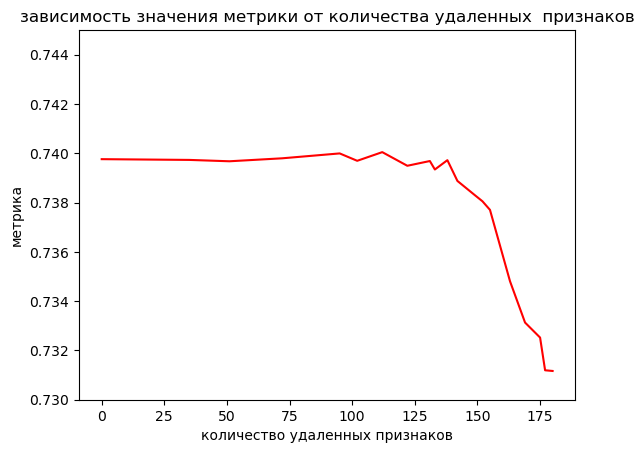

In [16]:
plt.plot( dropped_features_count,list_scores, color = "red")
plt.ylim(0.73, 0.745)
plt.xlabel("количество удаленных признаков")
plt.ylabel("метрика")
plt.title("зависимость значения метрики от количества удаленных  признаков")
plt.show();

In [17]:
X1 = val[best_features]
X1.shape

(900000, 116)

In [23]:
cv = cross_val_score(LGBMClassifier(verbose = -1), X1, y, cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring = "roc_auc")
print(round(cv.mean(),5), round(cv.std(),5))

0.74005 0.00302


In [24]:
l = ['sum_Loan5_op','sum_loan530_op','sum_loan3060_op' ,'sum_loan6090_op', 'sum_loan90_op', 'sum_open_credits', 'sum_over2limit_op', 'sum_maxover2limit_op',
'sum_Loan5_cd', 'sum_loan530_cd', 'sum_loan3060_cd','sum_loan6090_cd', 'sum_loan90_cd', 'sum_closed_credits', 'sum_maxover2limit_cd']
pairs = combinations(l,2)
pairs = list(pairs)
for a in np.arange(0.6,1, 0.1):
    pairs_list = []
    for pair in pairs:
        cor = X1[pair[0]].corr(X1[pair[1]])
        if cor > a:
            pairs_list.append(pair)
    print(a, pairs_list)

0.6 [('sum_loan3060_op', 'sum_loan6090_op'), ('sum_loan3060_op', 'sum_loan90_op'), ('sum_loan6090_op', 'sum_loan90_op'), ('sum_open_credits', 'sum_over2limit_op'), ('sum_open_credits', 'sum_maxover2limit_op'), ('sum_over2limit_op', 'sum_maxover2limit_op'), ('sum_loan530_cd', 'sum_maxover2limit_cd'), ('sum_loan3060_cd', 'sum_loan6090_cd'), ('sum_loan3060_cd', 'sum_loan90_cd'), ('sum_loan6090_cd', 'sum_loan90_cd')]
0.7 [('sum_loan3060_op', 'sum_loan6090_op'), ('sum_loan6090_op', 'sum_loan90_op'), ('sum_over2limit_op', 'sum_maxover2limit_op'), ('sum_loan530_cd', 'sum_maxover2limit_cd'), ('sum_loan3060_cd', 'sum_loan6090_cd'), ('sum_loan3060_cd', 'sum_loan90_cd'), ('sum_loan6090_cd', 'sum_loan90_cd')]
0.7999999999999999 [('sum_loan6090_op', 'sum_loan90_op'), ('sum_over2limit_op', 'sum_maxover2limit_op'), ('sum_loan3060_cd', 'sum_loan6090_cd'), ('sum_loan6090_cd', 'sum_loan90_cd')]
0.8999999999999999 [('sum_over2limit_op', 'sum_maxover2limit_op')]


In [58]:
X2 = X1.copy()
X2["ratio_credits"] = X2["sum_closed_credits"]/(X2[["sum_closed_credits", "sum_open_credits"]].sum(axis = 1))
X2 = X2.drop(columns = ['sum_over2limit_op'])

In [59]:
cv = cross_val_score(LGBMClassifier(verbose = -1), X2, y, cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring = "roc_auc")
print(round(cv.mean(),5), round(cv.std(),5))

0.7401 0.00379


In [28]:
X2["flag"] = val["flag"]
X2.to_parquet("C:/Users/vasan/ML итоговый проект/train_data/train_data/engineering/best_features.parquet")

## HyperParameters

In [30]:
X2 = pd.read_parquet("C:/Users/vasan/ML итоговый проект/train_data/train_data/engineering/best_features.parquet")


In [31]:
X2.shape

(900000, 117)

In [32]:
X3 = X2.drop(columns = "flag")
y3 = X2["flag"]

In [5]:
params_lgb = {
    "n_estimators" : hp.choice("n_estimators", np.arange(50,500,50)),
    "learning_rate" : hp.choice("learning-rate", np.arange(0.05, 10, 0.1)),
    "max_depth" : hp.choice("max_depth", np.arange(2,18,2)),
    "reg_alpha" : hp.choice("reg_alpha", np.arange(0.1, 10, 0.5)),
    "reg_lambda" : hp.choice("reg_lambda", np.arange(0.1, 10, 0.5)),
    "colsample_bytree" : hp.choice("colsample_bytree", np.arange(0.6, 1, 0.05)),
    "num_leaves" : hp.choice("num_leaves", range(20, 130, 20)),
    "class_weight" : hp.choice("class_weight", [{0:1, 1:3}, {0:1, 1:4}, "balanced"])
}
def hyp(params):
    pipeline = Pipeline(steps=[
        ("model", LGBMClassifier(**params, force_row_wise=True, verbose = -1))])
    cv = cross_val_score(pipeline, X3, y3, cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring = "roc_auc", n_jobs=-1).mean()

    return (-1)*cv
    


In [6]:
trials = Trials()

best_params = fmin(hyp, space = params_lgb, algo = tpe.suggest, max_evals = 50, trials = trials, catch_eval_exceptions=True, show_progressbar=True, early_stop_fn=no_progress_loss(15))

 72%|█████  | 36/50 [48:35<18:53, 80.99s/trial, best loss: -0.7463039751523335]


In [7]:
trials.best_trial["result"]

{'loss': -0.7463039751523335, 'status': 'ok'}

In [8]:
res = space_eval(params_lgb, trials.argmin)
res

{'class_weight': {0: 1, 1: 3},
 'colsample_bytree': np.float64(0.8000000000000002),
 'learning_rate': np.float64(0.05),
 'max_depth': np.int64(8),
 'n_estimators': np.int64(300),
 'num_leaves': 80,
 'reg_alpha': np.float64(8.6),
 'reg_lambda': np.float64(7.6)}

In [9]:
pipeline = Pipeline(steps=[
        ("model", LGBMClassifier(**res, verbose = -1))])
cv = cross_val_score(pipeline, X3, 3, cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring = "roc_auc", n_jobs=-1)
print(cv.mean(), cv.std())

0.7463039751523335 0.003334383605862446


In [6]:
params_xgb = {
    "n_estimators" : hp.choice("n_estimators",range(50, 500, 50)),
    "learning_rate" : hp.choice("learning_rate",np.arange(0.1, 5, 0.2)),
    "max_depth" : hp.choice("max_depth", range(2, 16, 2)),
    "reg_alpha" : hp.choice("reg_alpha", np.arange(0.1, 10, 0.2)),
    "reg_lambda" : hp.choice("reg_lambda", np.arange(0.1, 10, 0.1)),
    "colsample_bytree" : hp.choice("colsample_bytree", np.arange( 0.6, 1, 0.05)),
    "gamma" : hp.choice("gamma", range(0, 5)),
    'subsample': hp.choice("subsample", np.arange(0.1, 1, 0.05)),
    'colsample_bylevel': hp.choice("colsample_bylevel", np.arange(0.6, 1, 0.05))
}
def hyp(params):
    pipeline = Pipeline(steps=[
        ("model", XGBClassifier(**params,  verbose = -1))])
    cv = cross_val_score(pipeline, X3, y3, cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring = "roc_auc", n_jobs=-1).mean()

    return (-1)*cv
    


In [7]:
trials_xgb = Trials()

best_params = fmin(hyp, space = params_xgb, algo = tpe.suggest, max_evals = 50, trials = trials_xgb, catch_eval_exceptions=True, show_progressbar=True, early_stop_fn=no_progress_loss(15))

 36%|█  | 18/50 [1:14:20<2:12:09, 247.79s/trial, best loss: -0.743008420828868]


In [8]:
trials_xgb.best_trial["result"]

{'loss': -0.743008420828868, 'status': 'ok'}

In [10]:
res_xgb = space_eval(params_xgb, trials_xgb.argmin)
res_xgb

{'colsample_bylevel': np.float64(0.9500000000000003),
 'colsample_bytree': np.float64(0.7000000000000001),
 'gamma': 0,
 'learning_rate': np.float64(0.1),
 'max_depth': 8,
 'n_estimators': 150,
 'reg_alpha': np.float64(5.500000000000001),
 'reg_lambda': np.float64(6.0),
 'subsample': np.float64(0.8000000000000002)}

## Ensemble

In [33]:
x_train, x_test, y_train, y_test = train_test_split(X3, y3, test_size = 0.2, stratify = y3, shuffle = True, random_state = 42)

In [34]:
model_lgbm = LGBMClassifier(class_weight = {0: 1, 1: 3}, colsample_bytree = np.float64(0.8000000000000002), learning_rate = np.float64(0.05),
                            max_depth = np.int64(8), n_estimators = np.int64(300), num_leaves = 80, reg_alpha = np.float64(8.6), reg_lambda = np.float64(7.6), 
                            verbose = -1)
model_lgbm.fit(x_train, y_train)

LGBMClassifier(class_weight={0: 1, 1: 3},
               colsample_bytree=np.float64(0.8000000000000002),
               learning_rate=np.float64(0.05), max_depth=np.int64(8),
               n_estimators=np.int64(300), num_leaves=80,
               reg_alpha=np.float64(8.6), reg_lambda=np.float64(7.6),
               verbose=-1)

In [35]:
model_xgb = XGBClassifier(colsample_bylevel = np.float64(0.9500000000000003), colsample_bytree = np.float64(0.7000000000000001), gamma = 0,
                          learning_rate = np.float64(0.1), max_depth = 8, n_estimators = 150, reg_alpha = np.float64(5.500000000000001), reg_lambda = np.float64(6.0),
                          subsample = np.float64(0.8000000000000002))
model_xgb.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=np.float64(0.9500000000000003),
              colsample_bynode=None,
              colsample_bytree=np.float64(0.7000000000000001), device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=np.float64(0.1),
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, ...)

In [36]:
model_hist = HistGradientBoostingClassifier()
model_hist.fit(x_train, y_train)
#pred_hist = model_hist.predict_proba(x_test)[:,1]
#roc_auc_score(y_test, pred_hist)

HistGradientBoostingClassifier()

In [37]:
ensemble = VotingClassifier(estimators=[("a",model_lgbm), ("b", model_xgb), ("c", model_hist)], voting="soft")
cv = cross_val_score(ensemble, X3, y3, cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring="roc_auc")
print(cv.mean(), cv.std())

0.7470920741353272 0.003488242242394685


## Results

In [43]:
df["ratio_credits"] = df["sum_closed_credits"]/df[["sum_closed_credits", "sum_open_credits"]].sum(axis = 1)

In [44]:
X_total = df[X3.columns]
y_total = df["flag"]

In [47]:
cv_total = cross_val_score(ensemble, X_total, y_total, cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring="roc_auc")
print(f"""результаты кросс валидации на всем наборе данных
       среднее значение метрики roc_auc : {round(cv_total.mean(),5)}, 
       среднее значение стандартного отклонения : {round(cv_total.std(), 5)}""")

результаты кросс валидации на всем наборе данных
       среднее значение метрики roc_auc : 0.75225, 
       среднее значение стандартного отклонения : 0.00153
